In [1]:
import pandas as pd

all_train = pd.read_csv('./data/esun/train.csv')  

In [2]:
#Self train/test split, train = past 60 days data, test = last 30 days data

train = all_train[all_train['locdt']<=60]
test = all_train[all_train['locdt']>60]  

test_id = test['txkey']
del train['txkey']
del test['txkey']

# Preprocessing

missing value

In [3]:
#categorical
train[['flbmk', 'flg_3dsmk']] = train[['flbmk', 'flg_3dsmk']].fillna(value='Missing')
test[['flbmk', 'flg_3dsmk']] = test[['flbmk', 'flg_3dsmk']].fillna(value='Missing')

C:\Users\willy\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [4]:
def change_column_dtype_to_object(name): 
    train[name] = train[name].astype('object')
    test[name] = test[name].astype('object')

In [5]:
change_column_dtype_to_object("acqic")
change_column_dtype_to_object("bacno")
change_column_dtype_to_object("cano")
change_column_dtype_to_object("contp")
change_column_dtype_to_object("csmcu")
change_column_dtype_to_object("etymd")
change_column_dtype_to_object("hcefg")
change_column_dtype_to_object("mcc")
change_column_dtype_to_object("mchno")
change_column_dtype_to_object("scity")
change_column_dtype_to_object("stocn")
change_column_dtype_to_object("stscd")

C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# TODO : locdt cant use? delete?
# locdm either delete or change to something else, need preprocess, it represents HH:MM:SS
del train['loctm']
del test['loctm']

## Categorical column encoding

In [7]:
import numpy as np

In [8]:
cat_col_list = train.dtypes[train.dtypes == object].index.tolist()

# Unseen test categorical column values
solution: https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values

Too slow for this particular dataset, I'll use another method

Manual label encoding,runs much faster

In [9]:
# Manual label encoding,runs much faster

cat_col_ref_dict = dict()
for i in cat_col_list:
    #get unique values in the column to encode
    print("processing %s" % i)
    values = train[i].value_counts().index.tolist()

    # create a dictionary of values and corresponding number {value, number}
    dict_values = {value: count for value, count in zip(values, range(1,len(values)+1))}
    # save the values to encode in the dictionary
    cat_col_ref_dict[i] = dict_values

    # replace the values with the corresponding number from the dictionary
    train[i] = train[i].map(lambda x: dict_values.get(x))
    test[i] = test[i].map(lambda x: dict_values.get(x, 0 )) # add default unseen value = 0

processing acqic


C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


processing bacno
processing cano
processing contp
processing csmcu
processing ecfg
processing etymd
processing flbmk
processing flg_3dsmk
processing hcefg
processing insfg
processing mcc
processing mchno
processing ovrlt
processing scity
processing stocn
processing stscd


In [10]:
# test[test['mchno']==0]

In [11]:
#making sure those cateogrical variables are dtype "category"
#and use label encoding
for col in cat_col_list:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Modeling

In [12]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500) 

In [13]:
X = train.drop(['fraud_ind'], axis=1)
y = train[['fraud_ind']]

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=1337,stratify=y)

In [15]:
import numpy as np
import lightgbm as lgb

In [16]:
lgb_train = lgb.Dataset(X_train, y_train,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                        free_raw_data=False)

In [17]:
num_train, num_feature = X_train.shape

In [18]:
# generate feature names
# feature_name = ['feature_' + str(col) for col in range(num_feature)]
feature_name = X_train.columns.tolist()

In [19]:
categorical_features_indices = np.where(X.dtypes == "category")[0]

In [20]:
categorical_features_indices

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19],
      dtype=int64)

In [21]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'early_stopping_rounds' : 100,
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
    'verbose': 0
}

In [22]:
evals_result = {}  # to record eval results for plotting

In [23]:
%%time
print('Starting training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                feature_name=feature_name,
                categorical_feature=categorical_features_indices.tolist(),
                evals_result=evals_result
               )

Starting training...


C:\Users\willy\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\willy\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.0499158
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.0462975
[3]	valid_0's binary_logloss: 0.0436959
[4]	valid_0's binary_logloss: 0.0414526
[5]	valid_0's binary_logloss: 0.0396214
[6]	valid_0's binary_logloss: 0.0381047
[7]	valid_0's binary_logloss: 0.0367775
[8]	valid_0's binary_logloss: 0.0355631
[9]	valid_0's binary_logloss: 0.0344444
[10]	valid_0's binary_logloss: 0.0335391
[11]	valid_0's binary_logloss: 0.0326754
[12]	valid_0's binary_logloss: 0.0319575
[13]	valid_0's binary_logloss: 0.031267
[14]	valid_0's binary_logloss: 0.0306759
[15]	valid_0's binary_logloss: 0.0301644
[16]	valid_0's binary_logloss: 0.0296942
[17]	valid_0's binary_logloss: 0.029303
[18]	valid_0's binary_logloss: 0.0289177
[19]	valid_0's binary_logloss: 0.0285712
[20]	valid_0's binary_logloss: 0.0282655
[21]	valid_0's binary_logloss: 0.0279968
[22]	valid_0's binary_logloss: 0.0276935
[23]	valid_0's binary_logloss: 0.027464
[24]	va

[199]	valid_0's binary_logloss: 0.0248218
[200]	valid_0's binary_logloss: 0.0248051
[201]	valid_0's binary_logloss: 0.0258121
[202]	valid_0's binary_logloss: 0.0256169
[203]	valid_0's binary_logloss: 0.0256014
[204]	valid_0's binary_logloss: 0.0255983
[205]	valid_0's binary_logloss: 0.0256198
[206]	valid_0's binary_logloss: 0.0267879
[207]	valid_0's binary_logloss: 0.0255987
[208]	valid_0's binary_logloss: 0.0262711
[209]	valid_0's binary_logloss: 0.0300751
[210]	valid_0's binary_logloss: 0.0257044
[211]	valid_0's binary_logloss: 0.0256945
[212]	valid_0's binary_logloss: 0.0256722
[213]	valid_0's binary_logloss: 0.025654
[214]	valid_0's binary_logloss: 0.0256474
[215]	valid_0's binary_logloss: 0.0256442
[216]	valid_0's binary_logloss: 0.0256473
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.0227973
Wall time: 47.2 s


In [24]:
# feature names
print('Feature names:', gbm.feature_name())

# feature importances
print('Feature importances:', list(gbm.feature_importance()))

Feature names: ['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'locdt', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd']
Feature importances: [251, 1255, 548, 287, 24, 36, 28, 51, 13, 23, 0, 6, 14, 206, 208, 287, 8, 143, 50, 42]


feature importance plot

In [25]:
if lgb.compat.MATPLOTLIB_INSTALLED:
    import matplotlib.pyplot as plt
else:
    raise ImportError('You need to install matplotlib for plot_example.py.')

Plotting metrics recorded during training...


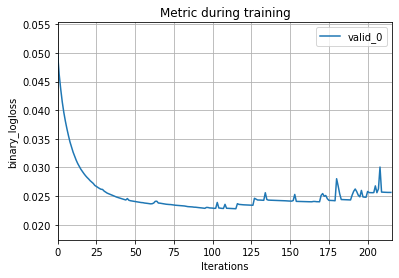

In [26]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()


Plotting feature importances...


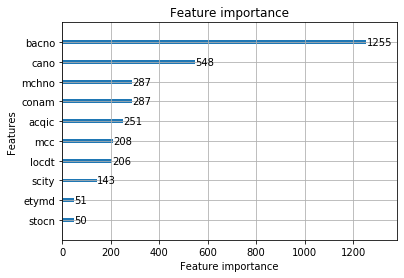

In [27]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

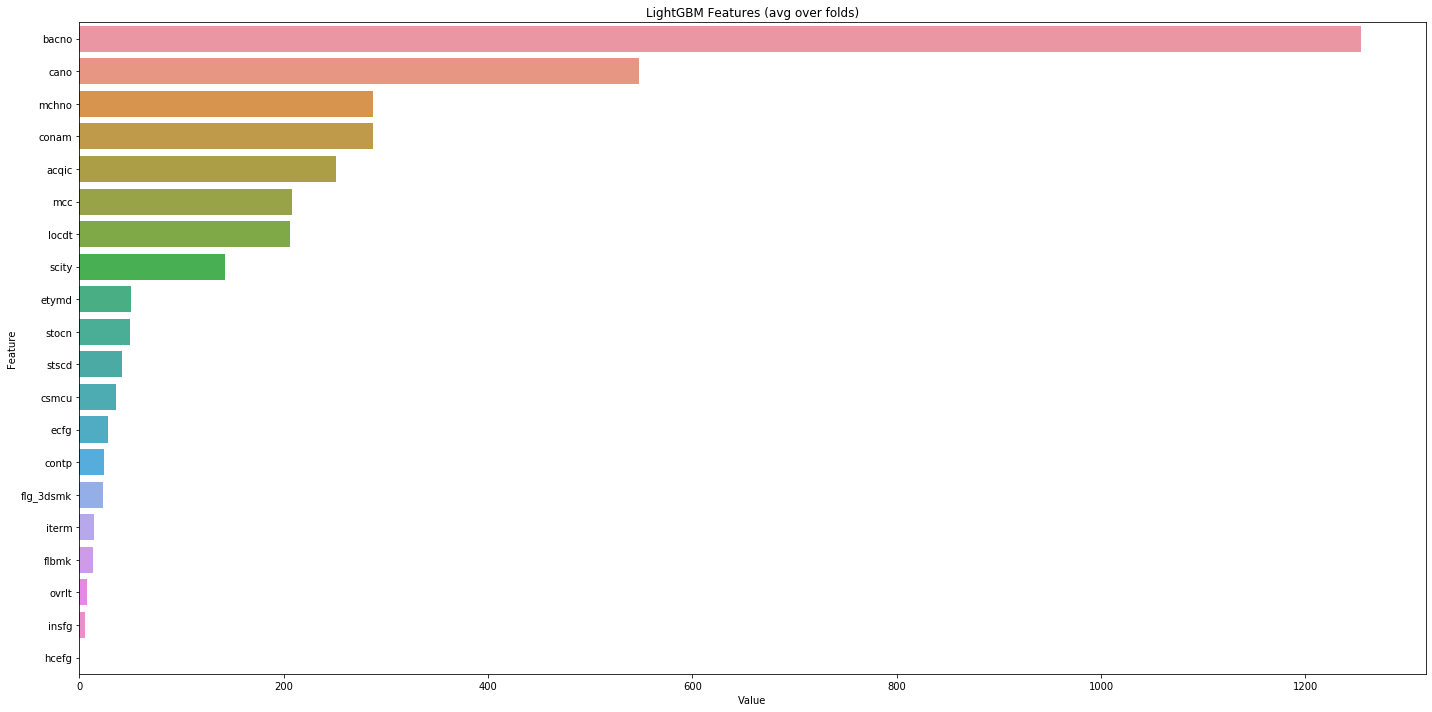

In [42]:
# more beautiful plot code

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

# Prediction for self-made test data

In [29]:
X_test = test.drop(['fraud_ind'], axis=1)
y_test = test['fraud_ind']

In [30]:
predictions_probs = gbm.predict(X_test)

# AUC score on self-made test data

In [31]:
pos_probs = predictions_probs

In [32]:
# import statistics
# median_predict_value = statistics.median(pos_probs)

In [33]:
# threshold = median_predict_value # threshold we set where the probability prediction must be above this to be classified as a '1'
# classes = predictions_probs.copy() # say it is the class in the second column you care about predictint
# classes[classes>=threshold] = 1
# classes[classes<threshold] = 0

In [34]:
# uniqueValues, occurCount = np.unique(classes, return_counts=True)
 
# print("Unique Values : " , uniqueValues)
# print("Occurrence Count : ", occurCount)

In [35]:
from sklearn import metrics

In [36]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_probs, pos_label=1)

In [37]:
roc_auc = metrics.auc(fpr, tpr)

In [38]:
lgb_auc = metrics.roc_auc_score(y_test, pos_probs)

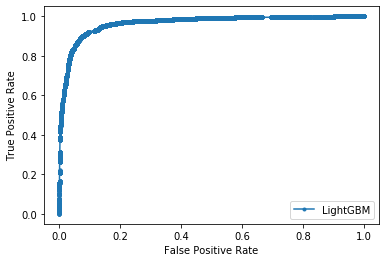

In [39]:
from matplotlib import pyplot
lgb_fpr, lgb_tpr, _ = metrics.roc_curve(y_test, pos_probs)
# plot the roc curve for the model
pyplot.plot(lgb_fpr, lgb_tpr, marker='.', label='LightGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [40]:
lgb_auc

0.9654085959505014